# Parsing simple commands

This example is a simplified version
of the language parsing model presented in
[Stewart & Eliasmith,
2013](http://compneuro.uwaterloo.ca/publications/stewart2013.html).
Please refer to that paper for the high-level details.

In [1]:
%matplotlib inline

import nengo
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0

## Step 1: Create the model

In [2]:
sequence = "WRITE ONE NONE WRITE TWO NONE THREE WRITE NONE".split()


def input_vision(t):
    index = int(t / 0.5) % len(sequence)
    return sequence[index]


# Number of dimensions for the SPs
dimensions = 64

# Make a model object with the SPA network
model = spa.Network(label="Parser", seed=seed)
n_per_dim = 50

with model:
    # Specify the modules to be used
    vision = spa.Transcode(input_vision, output_vocab=dimensions)
    phrase = spa.State(dimensions, neurons_per_dimension=n_per_dim)
    motor = spa.State(dimensions, neurons_per_dimension=n_per_dim)
    noun = spa.State(dimensions, feedback=1.0, neurons_per_dimension=n_per_dim)
    verb = spa.State(dimensions, feedback=1.0, neurons_per_dimension=n_per_dim)

    # Specify the action mapping
    none_vision_cond = spa.dot(
        spa.sym.NONE - spa.sym.WRITE - spa.sym.ONE - spa.sym.TWO - spa.sym.THREE, vision
    )
    num_vision_cond = spa.dot(vision, spa.sym.ONE + spa.sym.TWO + spa.sym.THREE)

    with spa.ActionSelection() as action_sel:
        spa.ifmax("Write vis", spa.dot(vision, spa.sym.WRITE), vision >> verb)
        spa.ifmax("Memorize", num_vision_cond, vision >> noun)
        spa.ifmax(
            "Write mem",
            0.5 * (none_vision_cond + spa.dot(phrase, spa.sym.WRITE * spa.sym.VERB)),
            phrase * ~spa.sym.NOUN >> motor,
        )

    noun * spa.sym.NOUN + verb * spa.sym.VERB >> phrase

## Step 2: Probe the output

In [3]:
with model:
    p_vision = nengo.Probe(vision.output, synapse=0.03)
    p_phrase = nengo.Probe(phrase.output, synapse=0.03)
    p_motor = nengo.Probe(motor.output, synapse=0.03)
    p_noun = nengo.Probe(noun.output, synapse=0.03)
    p_verb = nengo.Probe(verb.output, synapse=0.03)
    p_selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Step 3: Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(4.5)

## Step 4: Plot the results

Text(0, 0.5, 'Selected Action')

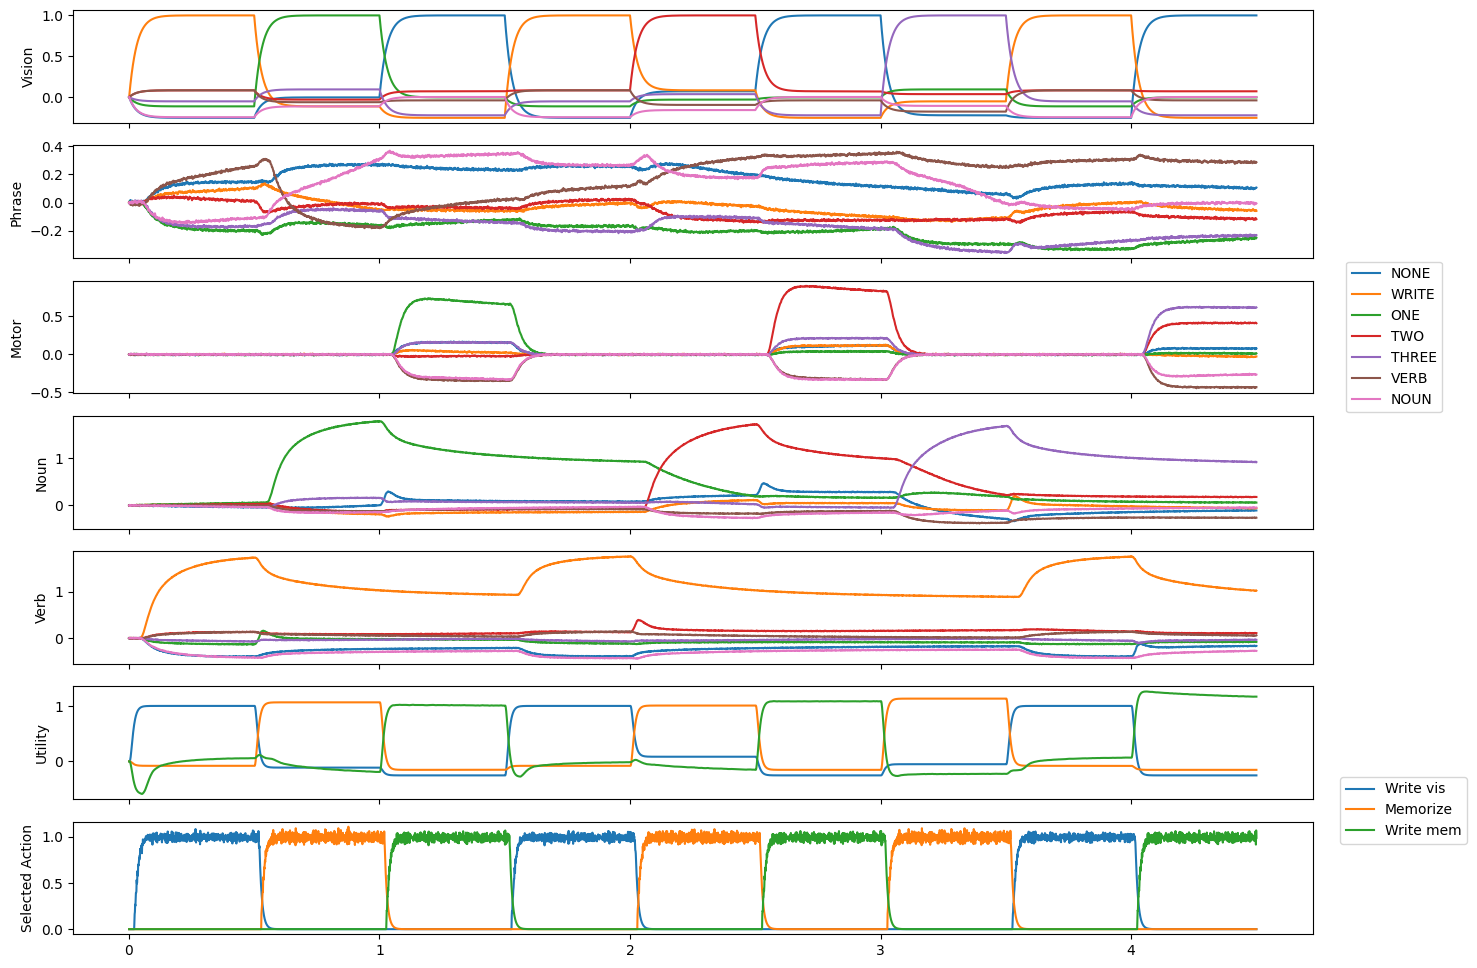

In [5]:
vocab = model.vocabs[dimensions]

fig, ax = plt.subplots(7, 1, sharex=True, figsize=(16, 12))

ax[0].plot(sim.trange(), spa.similarity(sim.data[p_vision], vocab))
ax[0].set_ylabel("Vision")

ax[1].plot(sim.trange(), spa.similarity(sim.data[p_phrase], vocab))
ax[1].set_ylabel("Phrase")

ax[2].plot(sim.trange(), spa.similarity(sim.data[p_motor], vocab))
ax[2].legend(vocab.keys(), loc="right", bbox_to_anchor=(1.11, 0.5))
ax[2].set_ylabel("Motor")

ax[3].plot(sim.trange(), spa.similarity(sim.data[p_noun], vocab))
ax[3].set_ylabel("Noun")

ax[4].plot(sim.trange(), spa.similarity(sim.data[p_verb], vocab))
ax[4].set_ylabel("Verb")

ax[5].plot(sim.trange(), sim.data[p_utility])
ax[5].legend(tuple(action_sel.keys()), loc="right", bbox_to_anchor=(1.13, -0.1))
ax[5].set_ylabel("Utility")

ax[6].plot(sim.trange(), sim.data[p_selected_actions])
ax[6].set_ylabel("Selected Action")